In [43]:
import numpy as np
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
wn = nltk.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
import re
import string

In [86]:
train=pd.read_csv('../input/Train.csv')
test=pd.read_csv('../input/Test.csv')
sample=pd.read_csv('../input/SampleSubmission.csv')

In [87]:
train.head(2)

,ID,text,label
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression
1,9JDAGUV3,Why do I get hallucinations?,Drugs


In [88]:
test.head(2)

,ID,text
0,02V56KMO,How to overcome bad feelings and emotions
1,03BMGTOK,I feel like giving up in life


In [89]:
train.isnull().sum(),test.isnull().sum(),train.shape,test.shape,train.dtypes

(ID       0
 text     0
 label    0
 dtype: int64,
 ID      0
 text    0
 dtype: int64,
 (616, 3),
 (309, 2),
 ID       object
 text     object
 label    object
 dtype: object)

In [90]:
df=train.append(test,ignore_index=True)

In [91]:
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r'@[a-zA-Z0-9_]+', '', text)   
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)   
    text = re.sub(r'www.[^ ]+', '', text)  
    text = re.sub(r'[a-zA-Z0-9]*www[a-zA-Z0-9]*com[a-zA-Z0-9]*', '', text)  
    text = re.sub(r'[^a-zA-Z]', ' ', text)   
    text = [token for token in text.split() if len(token) > 2]
    text = ' '.join(text)
    return text

df['text'] = df['text'].apply(clean_text)

In [92]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [93]:
import string
punctuation=string.punctuation
df['word_count']=df['text'].apply(lambda x: len(str(x).split(" ")))
df['char_count'] = df['text'].str.len()
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

df['avg_word'] = df['text'].apply(lambda x: avg_word(x))
from nltk.corpus import stopwords
stop = stopwords.words('english')

df['stopwords'] = df['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
df['numerics'] = df['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df['upper'] = df['text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
df['word_density'] = df['char_count'] / (df['word_count']+1)
df['punctuation_count'] = df['text'].apply(lambda x: len("".join(_ for _ in x if _ in punctuation)))

In [94]:
j=[]
for i in df['text']:
  j.append(len(i))
df['len']=j

In [95]:
from textblob import TextBlob
df['polarity'] = df.apply(lambda x: TextBlob(x['text']).sentiment.polarity, axis=1)
df['subjectivity'] = df.apply(lambda x: TextBlob(x['text']).sentiment.subjectivity, axis=1)

In [96]:
df.head(2)

,ID,text,label,word_count,char_count,avg_word,stopwords,numerics,upper,word_density,punctuation_count,len,polarity,subjectivity
0,SUAVK39Z,feel that was better dieam happy,Depression,6,32,4.500000,2,0,0,4.571429,0,32,0.65,0.75
1,9JDAGUV3,why get hallucinations,Drugs,3,22,6.666667,1,0,0,5.500000,0,22,0.00,0.00


In [97]:
train = df[df['label'].isnull()==False]
test = df[df['label'].isnull()==True]

In [98]:
train.head(2)

,ID,text,label,word_count,char_count,avg_word,stopwords,numerics,upper,word_density,punctuation_count,len,polarity,subjectivity
0,SUAVK39Z,feel that was better dieam happy,Depression,6,32,4.500000,2,0,0,4.571429,0,32,0.65,0.75
1,9JDAGUV3,why get hallucinations,Drugs,3,22,6.666667,1,0,0,5.500000,0,22,0.00,0.00


In [99]:
test.head(2)

,ID,text,label,word_count,char_count,avg_word,stopwords,numerics,upper,word_density,punctuation_count,len,polarity,subjectivity
616,02V56KMO,how overcome bad feelings and emotions,NaN,6,38,5.5,2,0,0,5.428571,0,38,-0.7,0.666667
617,03BMGTOK,feel like giving life,NaN,4,21,4.5,0,0,0,4.200000,0,21,0.0,0.000000


In [1]:
train['label'].value_counts()

NameError: name 'train' is not defined

In [ ]:
#del train['text']
#del test['text']
del test['label']

In [60]:
c=test['ID']
del train['ID']
del test['ID']

In [68]:
train['label']= train['label'].replace({'Depression': 3,'Alcohol': 2,'Suicide': 1, 'Drugs': 0})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [69]:
train_df=train
test_df=test

In [70]:
X = train_df.drop(labels=['label'], axis=1)
y = train_df['label'].values

In [71]:

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)


In [72]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((462, 11), (462,), (154, 11), (154,))

In [73]:
from sklearn.metrics import log_loss

In [78]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_cv, label=y_cv)

param = {'objective': 'multiclass',
         'num_class': 4,
         'boosting': 'gbdt',  
         'metric': 'multi_logloss',
         'learning_rate': 0.1, 
         'num_iterations': 2000,
         'num_leaves': 100,
         'max_depth': -1,
         'min_data_in_leaf': 15,
         'bagging_fraction':0.9,
         'bagging_freq': 1,
         'feature_fraction': 0.7,
         'lambda_l2': 0.8,
         'min_data_per_group': 75,
         'max_bin': 255,
         'is_unbalance':True
         }

clf = lgb.train(params=param, 
                early_stopping_rounds=200,
                verbose_eval=100,
                train_set=train_data,
                valid_sets=[test_data])

y_pred = clf.predict(X_cv)

Training until validation scores don't improve for 200 rounds
[100]	valid_0's multi_logloss: 1.30906
[200]	valid_0's multi_logloss: 1.55897
Early stopping, best iteration is:
[11]	valid_0's multi_logloss: 1.08436


In [79]:
log_loss(y_cv, y_pred)

1.0843584625001106

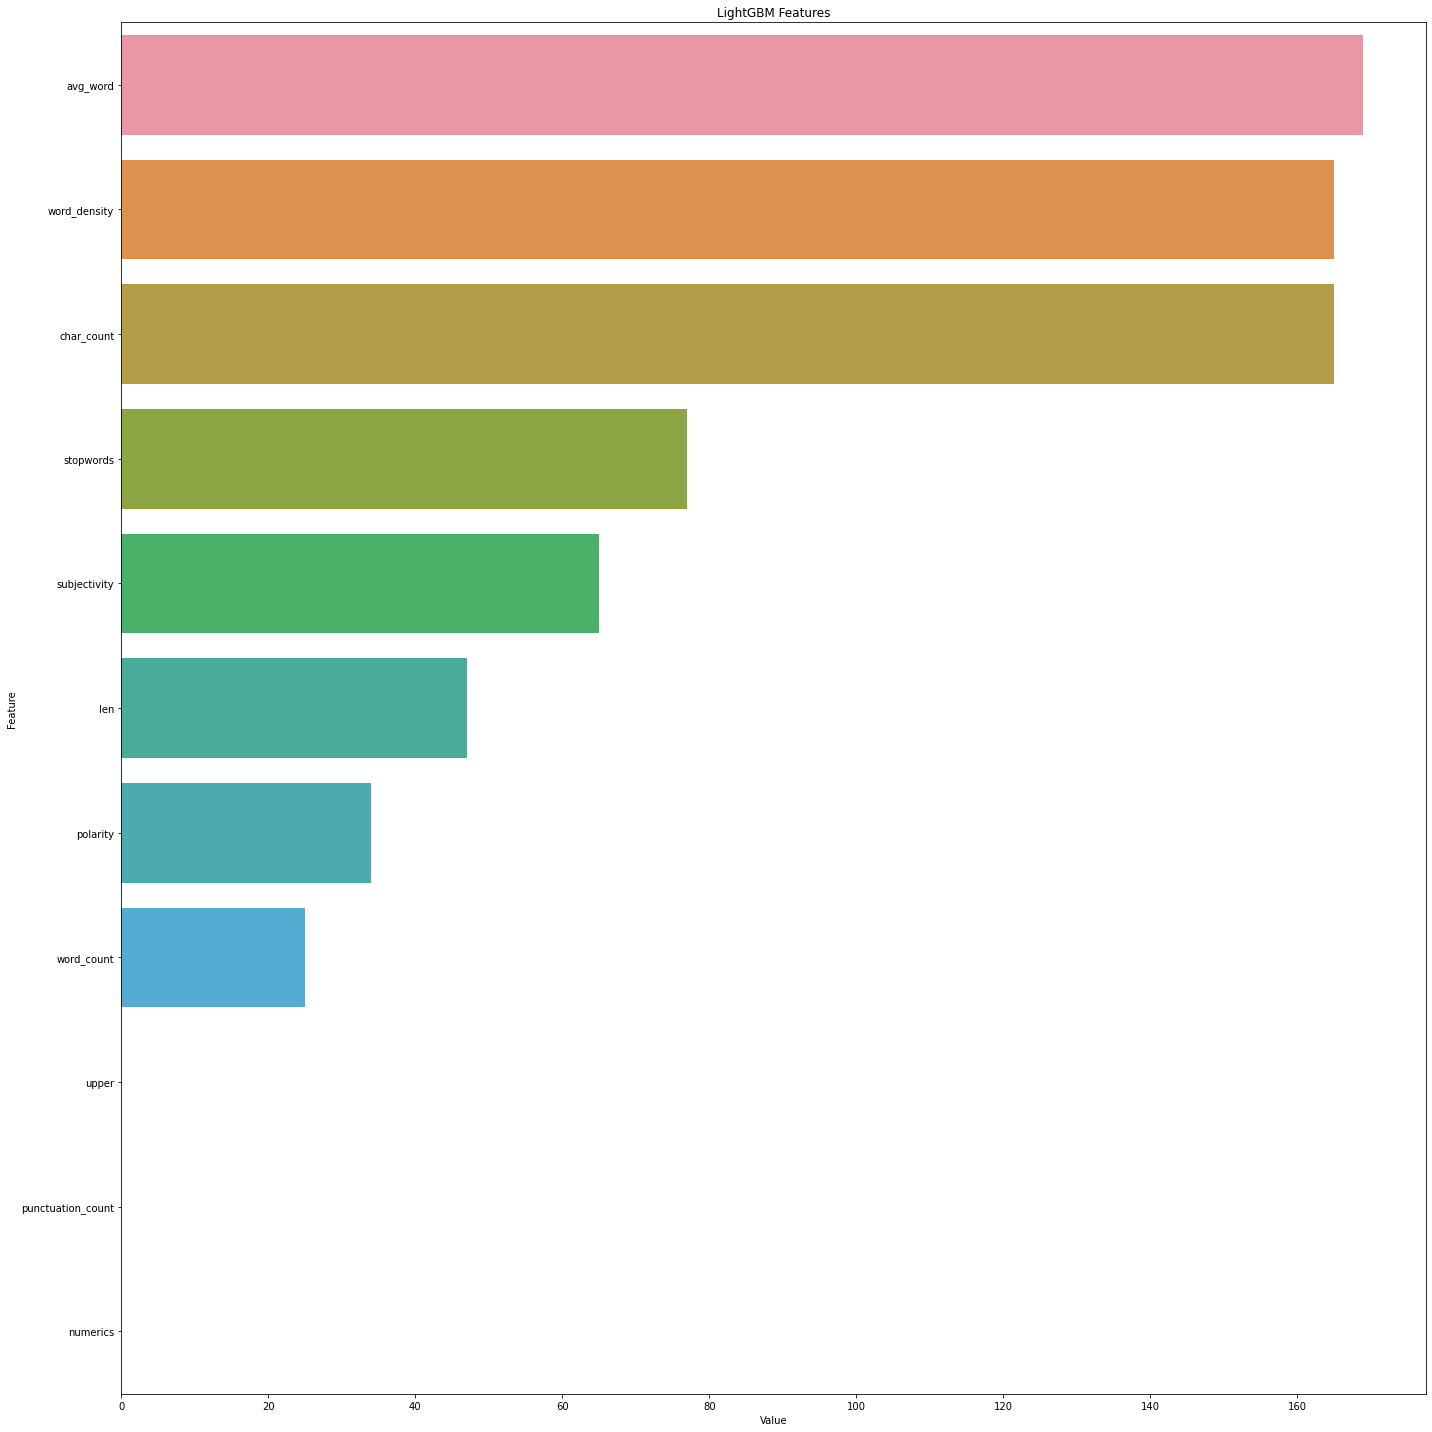

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy.stats import skew, norm
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(), X.columns), reverse=True)[:], columns=['Value','Feature'])
plt.figure(figsize=(20,20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [82]:

feature_imp.loc[feature_imp.Value >= 0].sort_values(by=['Value'], ascending = False)

,Value,Feature
0,169,avg_word
1,165,word_density
2,165,char_count
3,77,stopwords
4,65,subjectivity
5,47,len
6,34,polarity
7,25,word_count
8,0,upper
9,0,punctuation_count


In [83]:
Xtest = test_df

In [84]:

from sklearn.model_selection import KFold, StratifiedKFold

errlgb = []
y_pred_totlgb = []

fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=123456789)

for train_index, test_index in fold.split(X, y):
    
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)
    
    clf = lgb.train(params=param, 
                     early_stopping_rounds=200,
                     verbose_eval=100,
                     train_set=train_data,
                     valid_sets=[test_data])

    y_pred = clf.predict(X_test)
    print("Log Loss: ", (log_loss(y_test, y_pred)))
    
    errlgb.append(log_loss(y_test, y_pred))
    p = clf.predict(Xtest)
    y_pred_totlgb.append(p)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[100]	valid_0's multi_logloss: 1.18956
[200]	valid_0's multi_logloss: 1.41328
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 1.03863
Log Loss:  1.0386307142762932
Training until validation scores don't improve for 200 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 1.33723
[200]	valid_0's multi_logloss: 1.54633
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.10018
Log Loss:  1.100177379512593
Training until validation scores don't improve for 200 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 1.33903
[200]	valid_0's multi_logloss: 1.55692
Early stopping, best iteration is:
[11]	valid_0's multi_logloss: 1.07494
Log Loss:  1.0749437602371852
Training until validation scores don't improve for 200 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 1.37622
[200]	valid_0's multi_logloss: 1.67402
Early stopping, best iteration is:
[13]	valid_0's multi_logloss: 1.07882
Log Loss:  1.0788227786987574
Training until validation scores don't improve for 200 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 1.29464
[200]	valid_0's multi_logloss: 1.5419
Early stopping, best iteration is:
[10]	valid_0's multi_logloss: 1.10321
Log Loss:  1.103211682604315
Training until validation scores don't improve for 200 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 1.22641
[200]	valid_0's multi_logloss: 1.43289
Early stopping, best iteration is:
[21]	valid_0's multi_logloss: 1.0459
Log Loss:  1.045902629813008
Training until validation scores don't improve for 200 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 1.09814
[200]	valid_0's multi_logloss: 1.19305
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 1.00548
Log Loss:  1.0054813689031177
Training until validation scores don't improve for 200 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 1.50687
[200]	valid_0's multi_logloss: 1.74391
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.11474
Log Loss:  1.1147377965122063
Training until validation scores don't improve for 200 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 1.42899
[200]	valid_0's multi_logloss: 1.76203
Early stopping, best iteration is:
[3]	valid_0's multi_logloss: 1.1003
Log Loss:  1.1003007453748006
Training until validation scores don't improve for 200 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 1.23529
[200]	valid_0's multi_logloss: 1.4347
Early stopping, best iteration is:
[12]	valid_0's multi_logloss: 1.02576
Log Loss:  1.0257615687873265


In [85]:
np.mean(errlgb,0)

1.0687970424719602

In [ ]:
final['Depression'] =final[0];final['Alcohol'] =final[1];final['Suicide'] =final[2];final['Drugs'] =final[3]

In [ ]:
final.columns

In [ ]:
final=final[['ID', 'Depression', 'Alcohol', 'Suicide', 'Drugs']]

In [ ]:
final.head()

In [ ]:
final.to_csv('need1.csv', index=False)

In [ ]:
train.to_csv('k1.csv',index=False)
test.to_csv('k2.csv',index=False)